# Pandana network accessibility demo

This notebook uses pandana (v0.2) to download street network and points-of-interest data from OpenStreetMap and then calculate network accessibility to the points of interest. Note: pandana currently only runs on Python 2.

  - [Pandana documentation](https://udst.github.io/pandana/network.html)
  - [OSM Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API/Language_Guide) language documentation
  - [Overpass Turbo query demo](http://overpass-turbo.eu/s/hdj) for schools or bars near Berkeley/Oakland

For a simpler demo, check out [pandana-accessibility-demo-simple.ipynb](pandana-accessibility-demo-simple.ipynb)

In [1]:
import pandana, time, os, pandas as pd, numpy as np
from pandana.loaders import osm
%matplotlib inline

## 1. Set up configuration of script

In [2]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
amenities = ['restaurant', 'bar', 'school']
distance = 1000
num_pois = 10
num_categories = len(amenities) + 1 #one for each amenity, plus one extra for all of them combined

# bounding box as a list of llcrnrlat, llcrnrlng, urcrnrlat, urcrnrlng
#bbox = [37.7, -122.53, 37.82, -122.375] #san francisco
bbox = [37.76, -122.38, 37.9, -122.2] #berkeley/oakland

In [3]:
# configure filenames to save/load POI and network datasets
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data/network_{}.h5'.format(bbox_string)
poi_filename = 'data/pois_{}_{}.csv'.format('_'.join(amenities), bbox_string)

In [4]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

## 2. Download points of interest (POIs) and network data from OSM

First get the points of interest - either load an existing set for the specified amenities and bounding box from CSV, or get it from the OSM API.

In [5]:
start_time = time.time()
if os.path.isfile(poi_filename):
    # if a points-of-interest file already exists, just load the dataset from that
    pois = pd.read_csv(poi_filename)
    method = 'loaded from CSV'
else:   
    # otherwise, query the OSM API for the specified amenities within the bounding box 
    osm_tags = '"amenity"~"{}"'.format('|'.join(amenities))
    pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags=osm_tags)
    
    # using the '"amenity"~"school"' returns preschools etc, so drop any that aren't just 'school' then save to CSV
    pois = pois[pois['amenity'].isin(amenities)]
    pois.to_csv(poi_filename, index=False, encoding='utf-8')
    method = 'downloaded from OSM'
    
print('{:,} POIs {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['amenity', 'name', 'lat', 'lon']].head()

903 POIs loaded from CSV in 0.01 seconds


,amenity,name,lat,lon
0,restaurant,Berkeley Thai House,37.867150,-122.258297
1,restaurant,Herbivore The Earthly Grill,37.864796,-122.267140
2,restaurant,Pat Brown's Grille,37.873327,-122.264884
3,restaurant,Tako Sushi,37.867231,-122.258692
4,restaurant,Julie's Healthy Cafe,37.868647,-122.257546


In [6]:
# how many points of interest of each type of amenity did we retrieve?
pois['amenity'].value_counts()

restaurant    739
school         85
bar            79
Name: amenity, dtype: int64

Next get the street network data - either load an existing dataset for the specified bounding box from HDF5, or get it fresh from the OSM API.

In [7]:
start_time = time.time()
if os.path.isfile(net_filename):
    # if a street network file already exists, just load the dataset from that
    network = pandana.network.Network.from_hdf5(net_filename)
    method = 'loaded from HDF5'
else:
    # otherwise, query the OSM API for the street network within the specified bounding box
    network = osm.network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
    method = 'downloaded from OSM'
    
    # identify nodes that are connected to fewer than some threshold of other nodes within a given distance
    lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
    network.save_hdf5(net_filename, rm_nodes=lcn) #remove low-connectivity nodes and save to h5
    
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 19,956 nodes loaded from HDF5 in 1.57 secs


When saving a Network to HDF5 it’s possible to exclude certain nodes. This can be useful when refining a network so that it includes only validated nodes. As an example, you can use the low_connectivity_nodes() method to identify nodes that may not be connected to the larger network, then exclude those nodes when saving to HDF5. In the current design of Pandana it’s not possible to modify a Network in place. Instead, save the network (with low-connectivity nodes removed) to HDF5 and then load it from that file by re-starting the notebook.

## 3. Calculate accessibility to any amenity we retrieved

In [8]:
# precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [9]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [10]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
network.set_pois(category='all', x_col=pois['lon'], y_col=pois['lat'])

In [11]:
# searches for the n nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head()

19,956 nodes


,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
30366199,282.615997,399.686005,434.403992,521.252014,611.322998,822.515991,872.346985,1000.0,1000.0,1000.0
30366200,292.700012,319.678986,354.397003,441.244995,531.315979,742.508972,792.340027,1000.0,1000.0,1000.0
30374146,639.367004,655.778992,655.778992,655.778992,655.778992,921.804016,1000.000000,1000.0,1000.0,1000.0
33917655,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.0,1000.0
33947074,602.731018,657.486023,681.609985,776.804016,1000.000000,1000.000000,1000.000000,1000.0,1000.0,1000.0


## 4. Plot accessibility from each node to any amenity

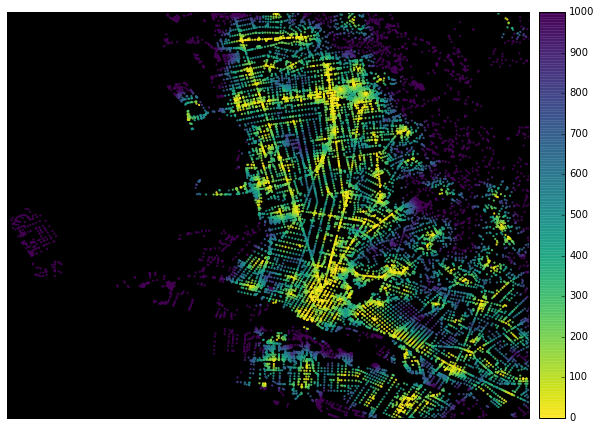

In [12]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)

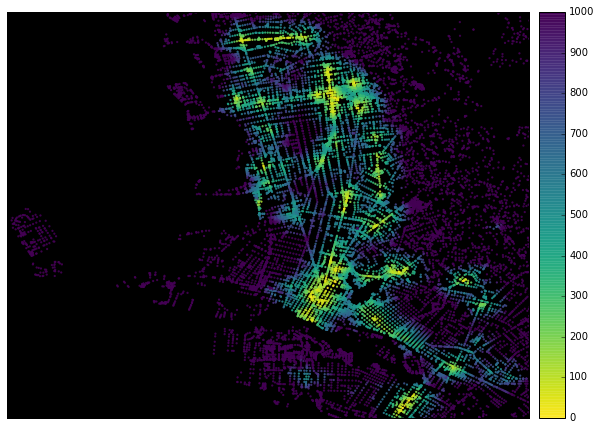

In [13]:
# distance to the 5th nearest amenity of any type
n = 5
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)

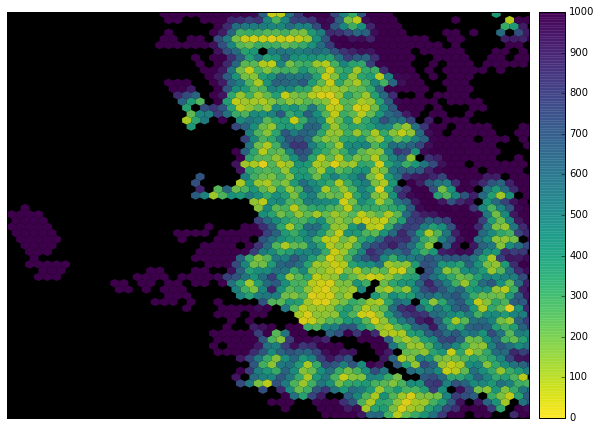

In [14]:
# distance to the nearest amenity of any type, as hexbins
bmap, fig, ax = network.plot(all_access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)

## 5. Calculate and plot accessibility separately for each amenity type

The amenity types specified at the beginning area: restaurants, bars, and schools

In [15]:
# initialize each amenity category with the locations specified by the lon and lat columns
for amenity in amenities:
    pois_subset = pois[pois['amenity']==amenity]
    network.set_pois(category=amenity, x_col=pois_subset['lon'], y_col=pois_subset['lat'])

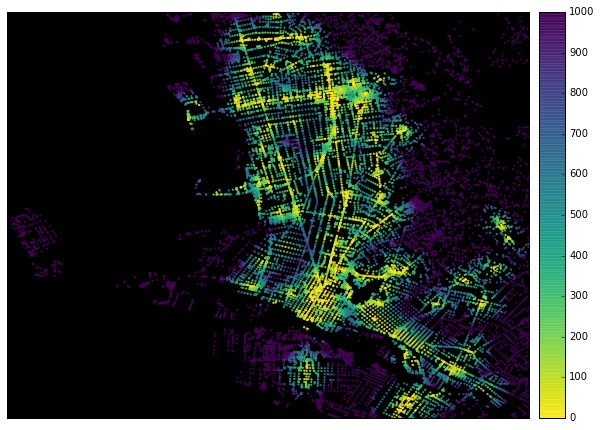

In [16]:
# distance to the nearest restaurant
restaurant_access = network.nearest_pois(distance=distance, category='restaurant', num_pois=num_pois)
bmap, fig, ax = network.plot(restaurant_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)

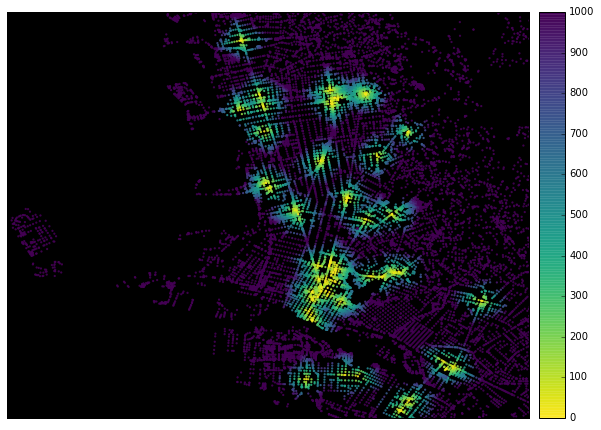

In [17]:
# distance to the nearest bar
bar_access = network.nearest_pois(distance=distance, category='bar', num_pois=num_pois)
bmap, fig, ax = network.plot(bar_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)

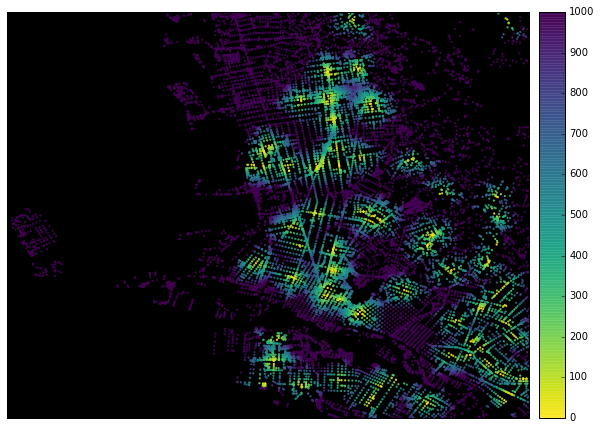

In [18]:
# distance to the nearest school
school_access = network.nearest_pois(distance=distance, category='school', num_pois=num_pois)
bmap, fig, ax = network.plot(school_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)

## 6. Network aggregation queries

Normally you'd want to do this with population or square footage or something similar. I'm just using 'capacity' because it's a variable that I can pull from OSM. But, only like one POI in this dataset has a positive value for capacity (and its value is 100 and it's in downtown Oakland).

In [19]:
# first get the nearest node_id for each POI, based on its lat-lon
pois['node_ids'] = network.get_node_ids(pois['lon'], pois['lat'])

In [20]:
# attach the value of the capacity variable to each corresponding node in the network
network.set(pois['node_ids'], variable=pois['capacity'], name='capacity')

Removed 901 rows because they contain missing values


In [21]:
# sum (with linear decay) the capacities within specified distance from each node in network
capacity_sum = network.aggregate(distance=distance, type='sum', decay='linear', name='capacity')

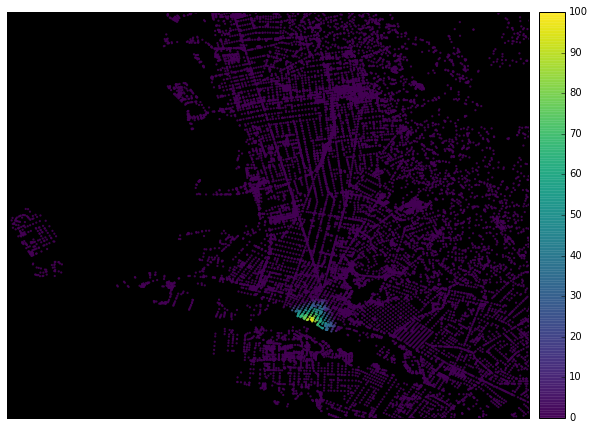

In [22]:
# plot the accessibility to 'capacity'
bmap, fig, ax = network.plot(capacity_sum, bbox=bbox, plot_type='scatter', plot_kwargs=agg_plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)

For a simpler demo, check out [pandana-accessibility-demo-simple.ipynb](pandana-accessibility-demo-simple.ipynb)